# Use spaCy to build Named-Entity Recognition (NER)
1. Dataset: [New York Times Relation Extraction Dataset](https://www.kaggle.com/datasets/daishinkan002/new-york-times-relation-extraction-dataset)
  - 14 types of NER labels, e.g. "LOCATION", "PERSON", "BUSINESS", "COUNTRY", etc.
  - training set: 56196 sentences
  - validation set: 5000 sentences
  - skewed data: most of the data belongs to 1 or 2 label categories.
  
2. Training Model: [spaCy transformer](https://spacy.io/usage/training) (roberta-base)
3. Possible optimizations:
  - Because this is an **imbalanced** dataset, we can optimize the training process by the options below:
    - Oversampling: increase minor data 
    - Undersampling: decrease majority data 
    - Cost-sensitive learning: assign balanced weights to each class, etc.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/REL/nyt_rel/dataset/

/content/drive/MyDrive/REL/nyt_rel/dataset


## 1. Dataset Overview
- Dataset: [New York Times Relation Extraction Dataset](https://www.kaggle.com/datasets/daishinkan002/new-york-times-relation-extraction-dataset)
  - 14 types of named-entity labels, e.g. 
    - "LOCATION", "PERSON", "BUSINESS", "COUNTRY", etc.
  - 24 types of relation labels, e.g. 
    - LOCATION - contains - LOCATION, 
    - LOCATION - capital - COUNTRY
    - BUSINESS - founders - COMPANY, etc.
  - Genre: news article
  - Training set: 56196 sentences
  - Validation set: 5000 sentences
  - Visualization: Matplotlib 

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_json("train.json", lines=True, encoding="utf-8")

In [ ]:
df

,sentText,articleId,relationMentions,entityMentions,sentId
0,Massachusetts ASTON MAGNA Great Barrington ; a...,/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Annandale-on-Hudson', 'em2Text':...","[{'start': 1, 'label': 'ORGANIZATION', 'text':...",1
1,North Carolina EASTERN MUSIC FESTIVAL Greensbo...,/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'North Carolina', 'em2Text': 'Gre...","[{'start': 0, 'label': 'LOCATION', 'text': 'No...",2
2,It will be the final movie credited to Debra H...,/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Debra Hill', 'em2Text': 'Haddonf...","[{'start': 0, 'label': 'LOCATION', 'text': 'De...",1
3,In a 3-0 victory over the Crew on Saturday in ...,/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Ohio', 'em2Text': 'Columbus', 'l...","[{'start': 0, 'label': 'LOCATION', 'text': 'Co...",1
4,"The United States ambassador to Mexico , Tony ...",/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Mexico', 'em2Text': 'Nuevo Lared...","[{'start': 0, 'label': 'LOCATION', 'text': 'Un...",1
...,...,...,...,...,...
56191,"Tanna 's big draw is Mount Yasur , one of the ...",/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Tanna', 'em2Text': 'Mount Yasur'...","[{'start': 0, 'label': 'PERSON', 'text': 'Tann...",2
56192,We flew Air Pacific -LRB- 800-227-4446 ; www.a...,/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Vanuatu', 'em2Text': 'Port Vila'...","[{'start': 0, 'label': 'ORGANIZATION', 'text':...",3
56193,"I think Westchester is changing , '' said Kenn...",/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Kenneth T. Jackson', 'em2Text': ...","[{'start': 0, 'label': 'PERSON', 'text': 'Kenn...",1
56194,Here we have a 172-acre island with four-star ...,/m/vinci8/data1/riedel/projects/relation/kb/ny...,"[{'em1Text': 'Ellis Island', 'em2Text': 'Manha...","[{'start': 0, 'label': 'LOCATION', 'text': 'Ma...",1


In [ ]:
df["sentText"][0]

'Massachusetts ASTON MAGNA Great Barrington ; also at Bard College , Annandale-on-Hudson , N.Y. , July 1-Aug .'

In [ ]:
df["relationMentions"][0]

[{'em1Text': 'Annandale-on-Hudson',
  'em2Text': 'Bard College',
  'label': '/location/location/contains'}]

### Label Distribution

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
labels = {}

for index, row in df.iterrows():
  for rel in df["relationMentions"][index]:
    ner = rel["label"].split("/")
    e1 = ner[1].upper()
    e2 = ner[2].upper()

    if e1 not in labels:
      labels[e1] = 0
    else:
      labels[e1] += 1

    if e2 not in labels:
      labels[e2] = 0
    else:
      labels[e2] += 1

print(labels)

{'LOCATION': 114190, 'PEOPLE': 18706, 'PERSON': 21844, 'BUSINESS': 6559, 'ADMINISTRATIVE_DIVISION': 5657, 'COUNTRY': 12375, 'COMPANY': 1360, 'DECEASED_PERSON': 1751, 'NEIGHBORHOOD': 4940, 'ETHNICITY': 59, 'SPORTS': 371, 'SPORTS_TEAM_LOCATION': 185, 'SPORTS_TEAM': 185, 'COMPANY_SHAREHOLDER': 248}


In [ ]:
# sort dict
sort_labels = dict(reversed(sorted(labels.items(), key=lambda item: item[1])))
sort_labels

{'LOCATION': 114190,
 'PERSON': 21844,
 'PEOPLE': 18706,
 'COUNTRY': 12375,
 'BUSINESS': 6559,
 'ADMINISTRATIVE_DIVISION': 5657,
 'NEIGHBORHOOD': 4940,
 'DECEASED_PERSON': 1751,
 'COMPANY': 1360,
 'SPORTS': 371,
 'COMPANY_SHAREHOLDER': 248,
 'SPORTS_TEAM': 185,
 'SPORTS_TEAM_LOCATION': 185,
 'ETHNICITY': 59}

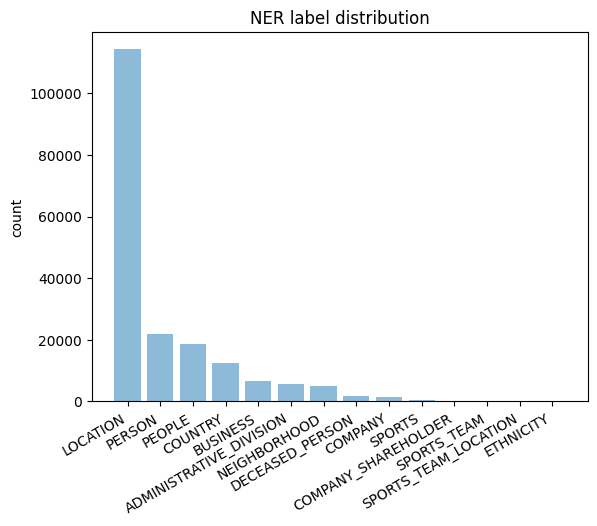

In [ ]:
x_labels = list(sort_labels.keys())
y = np.arange(len(x_labels))
count = list(sort_labels.values())

plt.bar(y, count, align='center', alpha=0.5)
plt.xticks(y, x_labels, rotation=30, ha='right')
# plt.xticks(rotation=30)
plt.ylabel('count')
plt.title('NER label distribution')

plt.show()

## 2. Training 
- [spaCy transformer](https://spacy.io/usage/training) (roberta-base)
- best model: 75% F1
- F1 = 2 * precision * recall / (precision + recall)
- precision = true positive / (true positive + false positive)
- recall = true positive / (true positive + false negative)
- Loss function: A loss function is a function that compares the target and predicted output values; measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.

In [ ]:
%cd /content/drive/MyDrive/REL/

/content/drive/MyDrive/REL


In [ ]:
!pip install spacy[transformers]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 768 kB/s 
     |████████████████████████████████| 1.1 MB 15.0 MB/s 
     |████████████████████████████████| 4.7 MB 84.0 MB/s 
     |████████████████████████████████| 182 kB 87.5 MB/s 
     |████████████████████████████████| 6.6 MB 75.6 MB/s 


In [ ]:
# spaCy model setting in config.cfg file
!python -m spacy init fill-config base_config.cfg config.cfg

2022-11-22 18:29:48.856009: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
!python -m spacy train config.cfg --gpu-id 0 --output ./output --paths.train ./nyt_rel/dataset/train_spacy_v2.spacy --paths.dev ./nyt_rel/dataset/valid_spacy_v2.spacy

2022-11-22 18:30:28.872830: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-22 18:30:37,891] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-22 18:30:37,902] [INFO] Pipeline: ['transformer', 'ner']
INFO:spacy:Pipeline: ['transformer', 'ner']
[2022-11-22 18:30:37,907] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-22 18:30:37,908] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.w